### LangChain Framework Introduction by PineCone.io
Learnt at https://www.pinecone.io/learn/series/langchain/langchain-conversational-memory/

I have updated the codes from the main repo because when I was running on Feb 2024, there were lots of updates in LangChain-OpenAI packages. So, the scripts will not be identical to the main repo.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/03-langchain-conversational-memory.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/03-langchain-conversational-memory.ipynb)

#### [LangChain Handbook](https://pinecone.io/learn/langchain)

# Conversational Memory

Conversational memory is how chatbots can respond to our queries in a chat-like manner. It enables a coherent conversation, and without it, every query would be treated as an entirely independent input without considering past interactions.

The memory allows a _"agent"_ to remember previous interactions with the user. By default, agents are *stateless* — meaning each incoming query is processed independently of other interactions. The only thing that exists for a stateless agent is the current input, nothing else.

There are many applications where remembering previous interactions is very important, such as chatbots. Conversational memory allows us to do that.

In this notebook we'll explore this form of memory in the context of the LangChain library.

We'll start by importing all of the libraries that we'll be using in this example.

In [7]:
# !pip install -qU langchain openai tiktoken
!pip install -U langchain-openai

In [8]:
import inspect

from getpass import getpass
from langchain_openai import ChatOpenAI
from langchain.chains import LLMChain, ConversationChain
from langchain.chains.conversation.memory import (ConversationBufferMemory, 
                                                  ConversationSummaryMemory, 
                                                  ConversationBufferWindowMemory,
                                                  ConversationKGMemory)
from langchain.callbacks import get_openai_callback
import tiktoken

To run this notebook, we will need to use an OpenAI LLM. Here we will setup the LLM we will use for the whole notebook, just input your openai api key when prompted. 

In [3]:
OPENAI_API_KEY = getpass()

In [9]:
llm = ChatOpenAI(
    temperature=0, 
    openai_api_key=OPENAI_API_KEY,
    model_name='gpt-3.5-turbo-0125'  # can be used with llms like 'gpt-3.5-turbo'
)

Later we will make use of a `count_tokens` utility function. This will allow us to count the number of tokens we are using for each call. We define it as so:

In [10]:
def count_tokens(chain, query):
    with get_openai_callback() as cb:
        result = chain.invoke(query)
        print(f'Spent a total of {cb.total_tokens} tokens')

    return result

Now let's dive into **Conversational Memory**.

## What is memory?

**Definition**: Memory is an agent's capacity of remembering previous interactions with the user (think chatbots)

The official definition of memory is the following:


> By default, Chains and Agents are stateless, meaning that they treat each incoming query independently. In some applications (chatbots being a GREAT example) it is highly important to remember previous interactions, both at a short term but also at a long term level. The concept of “Memory” exists to do exactly that.


As we will see, although this sounds really straightforward there are several different ways to implement this memory capability.

Before we delve into the different memory modules that the library offers, we will introduce the chain we will be using for these examples: the `ConversationChain`.

As always, when understanding a chain it is interesting to peek into its prompt first and then take a look at its `._call` method. As we saw in the chapter on chains, we can check out the prompt by accessing the `template` within the `prompt` attribute.

In [11]:
conversation = ConversationChain(
    llm=llm, 
)

In [12]:
print(conversation.prompt.template)

The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
{history}
Human: {input}
AI:


Interesting! So this chain's prompt is telling it to chat with the user and try to give truthful answers. If we look closely, there is a new component in the prompt that we didn't see when we were tinkering with the `LLMMathChain`: _history_. This is where our memory will come into play.

What is this chain doing with this prompt? Let's take a look.

In [13]:
print(inspect.getsource(conversation._call), inspect.getsource(conversation.apply))

    def _call(
        self,
        inputs: Dict[str, Any],
        run_manager: Optional[CallbackManagerForChainRun] = None,
    ) -> Dict[str, str]:
        response = self.generate([inputs], run_manager=run_manager)
        return self.create_outputs(response)[0]
     def apply(
        self, input_list: List[Dict[str, Any]], callbacks: Callbacks = None
    ) -> List[Dict[str, str]]:
        """Utilize the LLM generate method for speed gains."""
        callback_manager = CallbackManager.configure(
            callbacks, self.callbacks, self.verbose
        )
        run_manager = callback_manager.on_chain_start(
            dumpd(self),
            {"input_list": input_list},
        )
        try:
            response = self.generate(input_list, run_manager=run_manager)
        except BaseException as e:
            run_manager.on_chain_error(e)
            raise e
        outputs = self.create_outputs(response)
        run_manager.on_chain_end({"outputs": outputs})
        retur

Nothing really magical going on here, just a straightforward pass through an LLM. In fact, this chain inherits these methods directly from the `LLMChain` without any modification:

In [14]:
print(inspect.getsource(LLMChain._call), inspect.getsource(LLMChain.apply))

    def _call(
        self,
        inputs: Dict[str, Any],
        run_manager: Optional[CallbackManagerForChainRun] = None,
    ) -> Dict[str, str]:
        response = self.generate([inputs], run_manager=run_manager)
        return self.create_outputs(response)[0]
     def apply(
        self, input_list: List[Dict[str, Any]], callbacks: Callbacks = None
    ) -> List[Dict[str, str]]:
        """Utilize the LLM generate method for speed gains."""
        callback_manager = CallbackManager.configure(
            callbacks, self.callbacks, self.verbose
        )
        run_manager = callback_manager.on_chain_start(
            dumpd(self),
            {"input_list": input_list},
        )
        try:
            response = self.generate(input_list, run_manager=run_manager)
        except BaseException as e:
            run_manager.on_chain_error(e)
            raise e
        outputs = self.create_outputs(response)
        run_manager.on_chain_end({"outputs": outputs})
        retur

So basically this chain combines an input from the user with the conversation history to generate a meaningful (and hopefully truthful) response.

Now that we've understood the basics of the chain we'll be using, we can get into memory. Let's dive in!

## Memory types

In this section we will review several memory types and analyze the pros and cons of each one, so you can choose the best one for your use case.

### Memory type #1: ConversationBufferMemory

The `ConversationBufferMemory` does just what its name suggests: it keeps a buffer of the previous conversation excerpts as part of the context in the prompt.

**Key feature:** _the conversation buffer memory keeps the previous pieces of conversation completely unmodified, in their raw form._

In [15]:
conversation_buf = ConversationChain(
    llm=llm,
    memory=ConversationBufferMemory()
)

We pass a user prompt the the `ConversationBufferMemory` like so:

In [16]:
conversation_buf.invoke("Good morning AI!",)

c:\Users\Haripriya\anaconda3\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


{'input': 'Good morning AI!',
 'history': '',
 'response': 'Good morning! How are you today?'}

This one call used a total of `85` tokens, but we can't see that from the above. If we'd like to count the number of tokens being used we just pass our conversation chain object and the message we'd like to input via the `count_tokens` function we defined earlier:

In [17]:
count_tokens(
    conversation_buf, 
    "My interest here is to explore the potential of integrating Large Language Models with external knowledge"
)

Spent a total of 172 tokens


{'input': 'My interest here is to explore the potential of integrating Large Language Models with external knowledge',
 'history': 'Human: Good morning AI!\nAI: Good morning! How are you today?',
 'response': "That's a fascinating topic! Large Language Models like GPT-3 have shown great potential in generating human-like text, but integrating them with external knowledge sources could enhance their capabilities even further. By connecting these models with databases, websites, or other sources of information, they could provide more accurate and contextually relevant responses. Have you considered any specific approaches or tools for this integration?"}

In [34]:
count_tokens(
    conversation_buf,
    "I just want to analyze the different possibilities. What can you think of?"
)

Spent a total of 268 tokens


' Well, integrating Large Language Models with external knowledge can open up a lot of possibilities. For example, you could use them to generate more accurate and detailed summaries of text, or to answer questions about a given context more accurately. You could also use them to generate more accurate translations, or to generate more accurate predictions about future events.'

In [35]:
count_tokens(
    conversation_buf, 
    "Which data source types could be used to give context to the model?"
)

Spent a total of 360 tokens


'  There are a variety of data sources that could be used to give context to a Large Language Model. These include structured data sources such as databases, unstructured data sources such as text documents, and even audio and video data sources. Additionally, you could use external knowledge sources such as Wikipedia or other online encyclopedias to provide additional context.'

In [36]:
count_tokens(
    conversation_buf, 
    "What is my aim again?"
)

Spent a total of 388 tokens


' Your aim is to explore the potential of integrating Large Language Models with external knowledge.'

Our LLM with `ConversationBufferMemory` can clearly remember earlier interactions in the conversation. Let's take a closer look to how the LLM is saving our previous conversation. We can do this by accessing the `.buffer` attribute for the `.memory` in our chain.

In [37]:
print(conversation_buf.memory.buffer)


Human: Good morning AI!
AI:  Good morning! It's a beautiful day today, isn't it? How can I help you?
Human: My interest here is to explore the potential of integrating Large Language Models with external knowledge
AI:  Interesting! Large Language Models are a type of artificial intelligence that can process natural language and generate text. They can be used to generate text from a given context, or to answer questions about a given context. Integrating them with external knowledge can help them to better understand the context and generate more accurate results. Is there anything else I can help you with?
Human: I just want to analyze the different possibilities. What can you think of?
AI:  Well, integrating Large Language Models with external knowledge can open up a lot of possibilities. For example, you could use them to generate more accurate and detailed summaries of text, or to answer questions about a given context more accurately. You could also use them to generate more accu

Nice! So every piece of our conversation has been explicitly recorded and sent to the LLM in the prompt.

### Memory type #2: ConversationSummaryMemory

The problem with the `ConversationBufferMemory` is that as the conversation progresses, the token count of our context history adds up. This is problematic because we might max out our LLM with a prompt that is too large to be processed.

Enter `ConversationSummaryMemory`.

Again, we can infer from the name what is going on.. we will keep a summary of our previous conversation snippets as our history. How will we summarize these? LLM to the rescue.

**Key feature:** _the conversation summary memory keeps the previous pieces of conversation in a summarized form, where the summarization is performed by an LLM._

In this case we need to send the llm to our memory constructor to power its summarization ability.

In [18]:
conversation_sum = ConversationChain(
    llm=llm, 
    memory=ConversationSummaryMemory(llm=llm)
)

When we have an llm, we always have a prompt ;) Let's see what's going on inside our conversation summary memory:

In [19]:
print(conversation_sum.memory.prompt.template)

Progressively summarize the lines of conversation provided, adding onto the previous summary returning a new summary.

EXAMPLE
Current summary:
The human asks what the AI thinks of artificial intelligence. The AI thinks artificial intelligence is a force for good.

New lines of conversation:
Human: Why do you think artificial intelligence is a force for good?
AI: Because artificial intelligence will help humans reach their full potential.

New summary:
The human asks what the AI thinks of artificial intelligence. The AI thinks artificial intelligence is a force for good because it will help humans reach their full potential.
END OF EXAMPLE

Current summary:
{summary}

New lines of conversation:
{new_lines}

New summary:


Cool! So each new interaction is summarized and appended to a running summary as the memory of our chain. Let's see how this works in practice!

In [20]:
# without count_tokens we'd call `conversation_sum("Good morning AI!")`
# but let's keep track of our tokens:
count_tokens(
    conversation_sum, 
    "Good morning AI!"
)

Spent a total of 252 tokens


{'input': 'Good morning AI!',
 'history': '',
 'response': 'Good morning! How are you today?'}

In [21]:
count_tokens(
    conversation_sum, 
    "My interest here is to explore the potential of integrating Large Language Models with external knowledge"
)

Spent a total of 566 tokens


{'input': 'My interest here is to explore the potential of integrating Large Language Models with external knowledge',
 'history': 'The human greets the AI with a "Good morning." The AI responds with a friendly "Good morning! How are you today?"',
 'response': "That's a fascinating topic! Large Language Models like GPT-3 have shown great potential in generating human-like text, but integrating them with external knowledge sources could take their capabilities to the next level. By combining the vast amount of information stored in external knowledge bases with the language model's natural language processing abilities, we could potentially create AI systems that are even more intelligent and capable of understanding complex concepts. Do you have any specific ideas or goals in mind for this integration?"}

In [42]:
count_tokens(
    conversation_sum, 
    "I just want to analyze the different possibilities. What can you think of?"
)

Spent a total of 664 tokens


' I can think of a few possibilities. One option is to use a large language model to generate a set of candidate answers to a given query, and then use external knowledge to filter out the most relevant answers. Another option is to use the large language model to generate a set of candidate answers, and then use external knowledge to score and rank the answers. Finally, you could use the large language model to generate a set of candidate answers, and then use external knowledge to refine the answers.'

In [43]:
count_tokens(
    conversation_sum, 
    "Which data source types could be used to give context to the model?"
)

Spent a total of 799 tokens


' There are many different types of data sources that could be used to give context to the model. These could include structured data sources such as databases, unstructured data sources such as text documents, or even external APIs that provide access to external knowledge. Additionally, the model could be trained on a combination of these data sources to provide a more comprehensive understanding of the context.'

In [44]:
count_tokens(
    conversation_sum, 
    "What is my aim again?"
)

Spent a total of 853 tokens


' Your aim is to explore the potential of integrating Large Language Models with external knowledge.'

In [22]:
print(conversation_sum.memory.buffer)

The human greets the AI with a "Good morning." The AI responds with a friendly "Good morning! How are you today?" The human expresses interest in exploring the potential of integrating Large Language Models with external knowledge. The AI finds this topic fascinating and discusses how combining external knowledge sources with language models like GPT-3 could enhance their capabilities. The AI asks the human if they have any specific ideas or goals in mind for this integration.


You might be wondering.. if the aggregate token count is greater in each call here than in the buffer example, why should we use this type of memory? Well, if we check out buffer we will realize that although we are using more tokens in each instance of our conversation, our final history is shorter. This will enable us to have many more interactions before we reach our prompt's max length, making our chatbot more robust to longer conversations.

We can count the number of tokens being used (without making a call to OpenAI) using the `tiktoken` tokenizer like so:

In [23]:
# initialize tokenizer
tokenizer = tiktoken.encoding_for_model('gpt-3.5-turbo-0125')

# show number of tokens for the memory used by each memory type
print(
    f'Buffer memory conversation length: {len(tokenizer.encode(conversation_buf.memory.buffer))}\n'
    f'Summary memory conversation length: {len(tokenizer.encode(conversation_sum.memory.buffer))}'
)

Buffer memory conversation length: 113
Summary memory conversation length: 89


_Practical Note: the `text-davinci-003` and `gpt-3.5-turbo` models [have](https://platform.openai.com/docs/api-reference/completions/create#completions/create-max_tokens) a large max tokens count of 4096 tokens between prompt and answer._

### Memory type #3: ConversationBufferWindowMemory

Another great option for these cases is the `ConversationBufferWindowMemory` where we will be keeping a few of the last interactions in our memory but we will intentionally drop the oldest ones - short-term memory if you'd like. Here the aggregate token count **and** the per-call token count will drop noticeably. We will control this window with the `k` parameter.

**Key feature:** _the conversation buffer window memory keeps the latest pieces of the conversation in raw form_

In [24]:
conversation_bufw = ConversationChain(
    llm=llm, 
    memory=ConversationBufferWindowMemory(k=1)
)

In [25]:
count_tokens(
    conversation_bufw, 
    "Good morning AI!"
)

Spent a total of 75 tokens


{'input': 'Good morning AI!',
 'history': '',
 'response': 'Good morning! How are you today?'}

In [26]:
count_tokens(
    conversation_bufw, 
    "My interest here is to explore the potential of integrating Large Language Models with external knowledge"
)

Spent a total of 195 tokens


{'input': 'My interest here is to explore the potential of integrating Large Language Models with external knowledge',
 'history': 'Human: Good morning AI!\nAI: Good morning! How are you today?',
 'response': "That's a fascinating topic! Large Language Models like GPT-3 have shown great potential in generating human-like text, but integrating them with external knowledge sources could greatly enhance their capabilities. There are already efforts underway to connect these models with databases, websites, and other sources of information to make them more contextually aware and accurate in their responses. It's an exciting area of research with a lot of potential for innovation and advancement. What specific aspects of this integration are you interested in exploring further?"}

In [63]:
count_tokens(
    conversation_bufw, 
    "I just want to analyze the different possibilities. What can you think of?"
)

Spent a total of 233 tokens


' There are many possibilities for integrating Large Language Models with external knowledge. For example, you could use external knowledge to provide additional context to the model, or to provide additional training data. You could also use external knowledge to help the model better understand the context of a given text, or to help it generate more accurate results.'

In [64]:
count_tokens(
    conversation_bufw, 
    "Which data source types could be used to give context to the model?"
)

Spent a total of 245 tokens


' Data sources that could be used to give context to the model include text corpora, structured databases, and ontologies. Text corpora provide a large amount of text data that can be used to train the model and provide additional context. Structured databases provide structured data that can be used to provide additional context to the model. Ontologies provide a structured representation of knowledge that can be used to provide additional context to the model.'

In [65]:
count_tokens(
    conversation_bufw, 
    "What is my aim again?"
)

Spent a total of 186 tokens


' Your aim is to use data sources to give context to the model.'

As we can see, it effectively 'fogot' what we talked about in the first interaction. Let's see what it 'remembers'. Given that we set k to be `1`, we would expect it remembers only the last interaction.

We need to access a special method here since, in this memory type, the buffer is first passed through this method to be sent later to the llm.

In [27]:
bufw_history = conversation_bufw.memory.load_memory_variables(
    inputs=[]
)['history']

In [28]:
print(bufw_history)

Human: My interest here is to explore the potential of integrating Large Language Models with external knowledge
AI: That's a fascinating topic! Large Language Models like GPT-3 have shown great potential in generating human-like text, but integrating them with external knowledge sources could greatly enhance their capabilities. There are already efforts underway to connect these models with databases, websites, and other sources of information to make them more contextually aware and accurate in their responses. It's an exciting area of research with a lot of potential for innovation and advancement. What specific aspects of this integration are you interested in exploring further?


Makes sense. 

On the plus side, we are shortening our conversation length when compared to buffer memory _without_ a window:

In [68]:
print(
    f'Buffer memory conversation length: {len(tokenizer.encode(conversation_buf.memory.buffer))}\n'
    f'Summary memory conversation length: {len(tokenizer.encode(conversation_sum.memory.buffer))}\n'
    f'Buffer window memory conversation length: {len(tokenizer.encode(bufw_history))}'
)

Buffer memory conversation length: 334
Summary memory conversation length: 219
Buffer window memory conversation length: 26


_Practical Note: We are using `k=2` here for illustrative purposes, in most real world applications you would need a higher value for k._

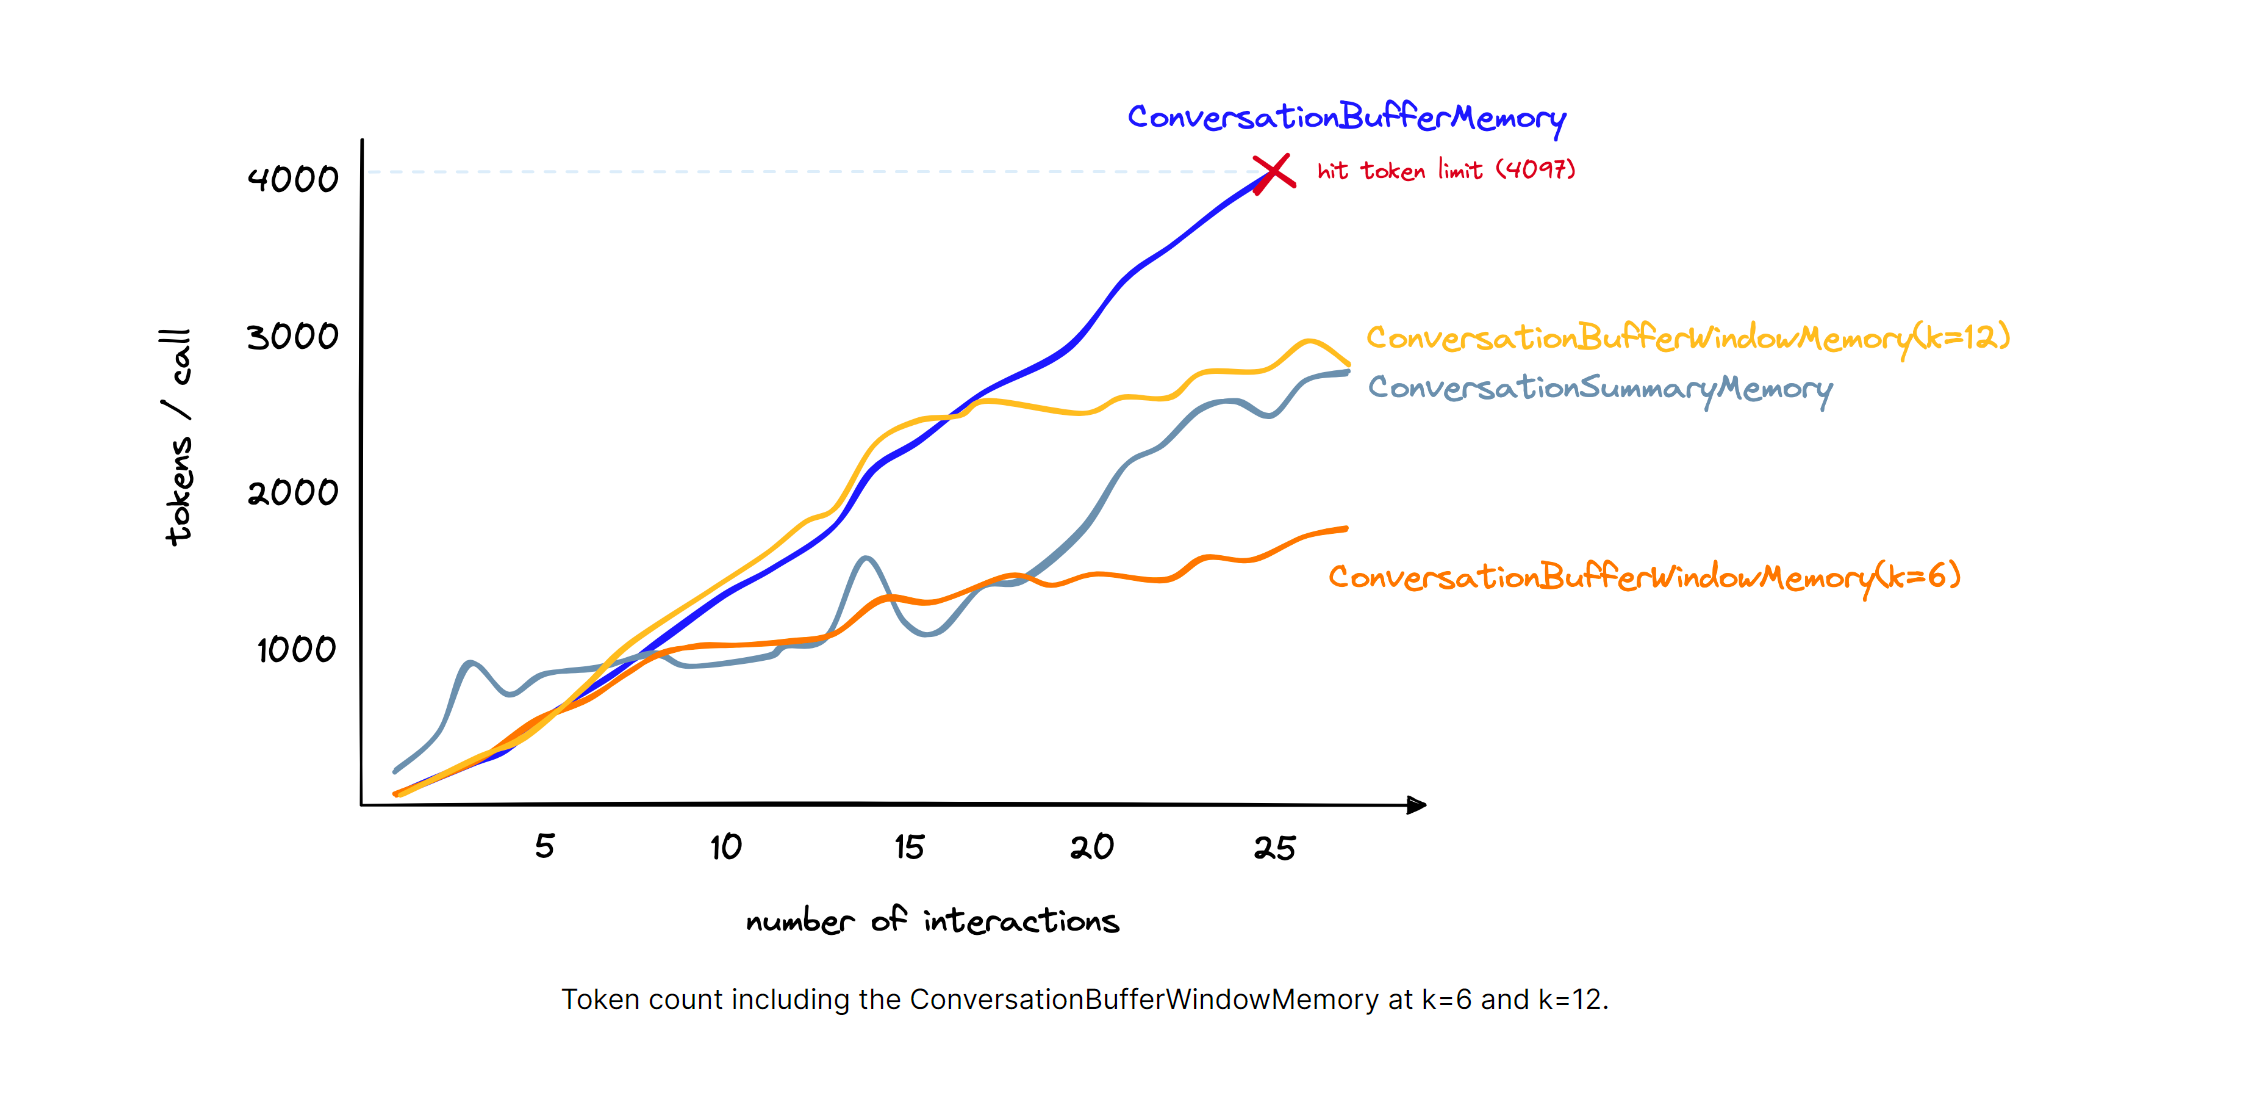
<!-- <img src="image.png" alt="image.png" width="200"/> -->

### More memory types!

Given that we understand memory already, we will present a few more memory types here and hopefully a brief description will be enough to understand their underlying functionality.

#### ConversationSummaryBufferMemory

**Key feature:** _the conversation summary memory keeps a summary of the earliest pieces of conversation while retaining a raw recollection of the latest interactions._

#### ConversationKnowledgeGraphMemory

This is a super cool memory type that was introduced just [recently](https://twitter.com/LangChainAI/status/1625158388824043522). It is based on the concept of a _knowledge graph_ which recognizes different entities and connects them in pairs with a predicate resulting in (subject, predicate, object) triplets. This enables us to compress a lot of information into highly significant snippets that can be fed into the model as context. If you want to understand this memory type in more depth you can check out [this](https://apex974.com/articles/explore-langchain-support-for-knowledge-graph) blogpost.

**Key feature:** _the conversation knowledge graph memory keeps a knowledge graph of all the entities that have been mentioned in the interactions together with their semantic relationships._

In [69]:
# you may need to install this library
# !pip install -qU networkx

In [70]:
conversation_kg = ConversationChain(
    llm=llm, 
    memory=ConversationKGMemory(llm=llm)
)

In [71]:
count_tokens(
    conversation_kg, 
    "My name is human and I like mangoes!"
)

Spent a total of 1565 tokens


" Hi Human! My name is AI. It's nice to meet you. I like mangoes too! Did you know that mangoes are a great source of vitamins A and C?"

The memory keeps a knowledge graph of everything it learned so far.

In [72]:
conversation_kg.memory.kg.get_triples()

[('human', 'human', 'name'), ('human', 'mangoes', 'likes')]

#### ConversationEntityMemory

**Key feature:** _the conversation entity memory keeps a recollection of the main entities that have been mentioned, together with their specific attributes._

The way this works is quite similar to the `ConversationKnowledgeGraphMemory`, you can refer to the [docs](https://python.langchain.com/en/latest/modules/memory/types/entity_summary_memory.html) if you want to see it in action. 

## What else can we do with memory?

There are several cool things we can do with memory in langchain. We can:
* implement our own custom memory module
* use multiple memory modules in the same chain
* combine agents with memory and other tools

If this piques your interest, we suggest you to go take a look at the memory [how-to](https://langchain.readthedocs.io/en/latest/modules/memory/how_to_guides.html) section in the docs!